In [1]:
import pandas as pd
df = pd.read_csv('Scrapper/final.csv', header=None)
df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

In [2]:
# df.head()
df.category.unique()

array(['positive', 'suggestion', 'question', 'other', 'correction',
       'negative'], dtype=object)

In [3]:
df['category_id'] = df['category'].factorize()[0]
df.head()

,comment,category,category_id
0,Love you sir!!,positive,0
1,Please make videos on..Midpoint circle drawing...,suggestion,1
2,I bought both of your courses on Udemy. You ar...,question,2
3,"Thank you very much, u really got me in the fi...",positive,0
4,i hope u are ok with everything going on again...,other,3


In [4]:
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [comment, category, category_id]
Index: []


In [5]:
# preprocessing
import re

# lowercasing
df['comment'] = df['comment'].str.lower()

# removing urls
df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)

# removing commas "\n"
df['comment'] = df['comment'].replace('\n','', regex=True)

# removing all the punctuations
df["comment"] = df['comment'].str.replace('[^\w\s]','')

# removing integers
df['comment'] = df['comment'].replace('\d','', regex=True)

# removing emojis
df['comment'] = df['comment'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
df

,comment,category,category_id
0,love you sir,positive,0
1,please make videos onmidpoint circle drawing a...,suggestion,1
2,i bought both of your courses on udemy you are...,question,2
3,thank you very much u really got me in the fir...,positive,0
4,i hope u are ok with everything going on again...,other,3
...,...,...,...
1032,can i get those ipynb files it will be really...,question,2
1033,brilliant good work,positive,0
1034,nicely explained,positive,0
1035,thank you very informative session,positive,0


In [6]:
# # correcting the typos
# from autocorrect import Speller

# spell = Speller(lang='en')

# def typo_corrector(text):
#     return spell(text)

# df['comment'] = df['comment'].apply(typo_corrector)
# df

In [7]:
# stemming
import nltk

stemmer = nltk.stem.SnowballStemmer('english')
def stem_text(text):
    return stemmer.stem(text)

df['comment'] = df['comment'].apply(stem_text)


# lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df['comment'] = df['comment'].apply(lemmatize_text)
df

,comment,category,category_id
0,love you sir,positive,0
1,please make videos onmidpoint circle drawing a...,suggestion,1
2,i bought both of your courses on udemy you are...,question,2
3,thank you very much u really got me in the fir...,positive,0
4,i hope u are ok with everything going on again...,other,3
...,...,...,...
1032,can i get those ipynb files it will be really...,question,2
1033,brilliant good work,positive,0
1034,nicely explained,positive,0
1035,thank you very informative session,positive,0


In [22]:
# category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
# category_to_id = dict(category_id_df.values)
# id_to_category = dict(category_id_df[['category_id', 'category']].values)
# df.head()

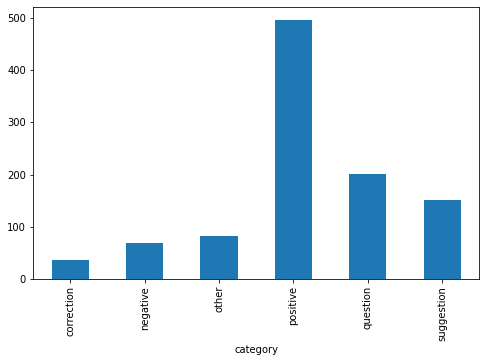

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
df.groupby('category').comment.count().plot.bar(ylim=0)
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.01, norm='l2', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.comment).toarray()
labels = df.category_id
features.shape

(1037, 99)

In [11]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 2

# for Product, category_id in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(Product))
#     print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['category_id'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [13]:
print(clf.predict(count_vect.transform(["please upload"])))

['suggestion']


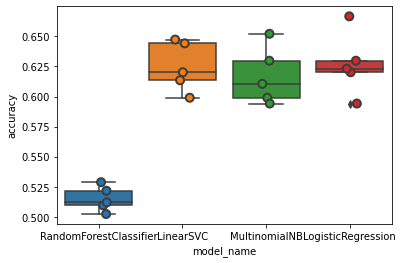

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

cv_df = pd.DataFrame()
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy')
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [15]:
cv_df.index

RangeIndex(start=0, stop=20, step=1)

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.624865
LogisticRegression        0.626812
MultinomialNB             0.617159
RandomForestClassifier    0.514939
Name: accuracy, dtype: float64

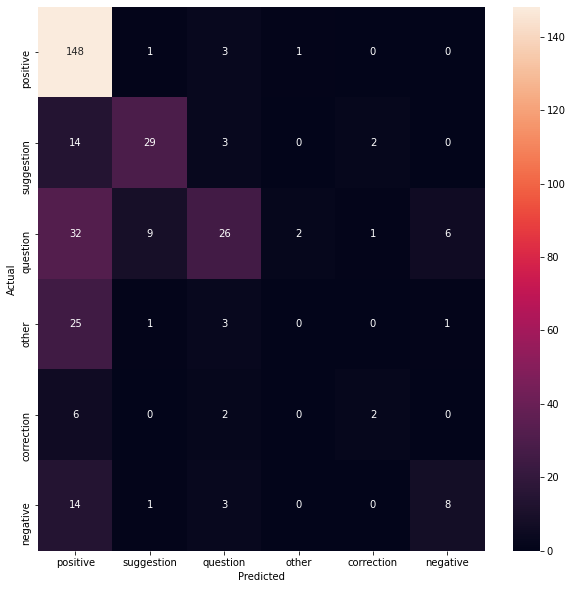

In [26]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
# from IPython.display import display

# for predicted in category_id_df.category_id:
#   for actual in category_id_df.category_id:
#     if predicted != actual and conf_mat[actual, predicted] >= 10:
#       print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
#       display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'comment']])
#       print('')

'suggestion' predicted as 'positive' : 14 examples.


,category,comment
142,suggestion,assalamualaikum teacher may allah give you a g...
239,suggestion,sir please continue on your java series plz si...
818,suggestion,sir i couldnt understand when we go from nod...
54,suggestion,please consider making your previous video pri...
521,suggestion,awesome explanations it would be better if you...
746,suggestion,my breaks button is in light gray please help
527,suggestion,wish english subtitle closed captioning shoul...
386,suggestion,sir last sem due to you alone i survived algor...
839,suggestion,please finish this cours
745,suggestion,i love this video please dont ever take it down



'question' predicted as 'positive' : 32 examples.


,category,comment
447,question,thank you so much excellent work can we avoid ...
294,question,what is c in d formula
200,question,sir while finding value of c c that time...
826,question,this video isnt at its correct position in the...
935,question,indian acc
1032,question,can i get those ipynb files it will be really...
783,question,any srmites her
688,question,what was that
810,question,why t is not being included in this t is also ...
283,question,hello at p ie how yy



'other' predicted as 'positive' : 25 examples.


,category,comment
936,other,nice basic introduction to nlp its a very good...
646,other,sick jacket
403,other,dimaag hil gaya
85,other,there is no requirement of subtitle it working...
952,other,shes got that i wonder which one of you nerds ...
955,other,what if i tell you that we will not be able to...
656,other,nit durgapurian xd
970,other,linuxgoogle job itervuiew
432,other,come to brazil
605,other,sot lagani hai



'negative' predicted as 'positive' : 14 examples.


,category,comment
741,negative,u fuckin idiot
672,negative,what the f is volews ive been a programmer fo...
511,negative,thank u sirbut the video is uploaded in low qu...
608,negative,this is dsa btree not database b tree nonsens
729,negative,who the fuck designed word
686,negative,my dick is tired of learning so much
648,negative,thx for insertion but deletion is not prop
667,negative,very bad explanation simply reading from the b...
723,negative,which matherfucker made ms word even page can...
603,negative,not good its not the video lecture that you w


In [21]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['category'].unique()))

              precision    recall  f1-score   support

    positive       0.62      0.97      0.76       153
  suggestion       0.71      0.60      0.65        48
    question       0.65      0.34      0.45        76
       other       0.00      0.00      0.00        30
  correction       0.40      0.20      0.27        10
    negative       0.53      0.31      0.39        26

    accuracy                           0.62       343
   macro avg       0.48      0.40      0.42       343
weighted avg       0.57      0.62      0.56       343

